# Machine Learning and Comic Book Characters
Ariana Olson, Emma Price

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import thinkstats2
import thinkplot

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.models
import keras.layers

import pickle

## Explore the data

In [39]:
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)
    
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)
    
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)

In [40]:
both_df = pd.read_hdf('both_df.hdf5', key='both')
marvel_df = pd.read_hdf('marvel_df.hdf5', key='marvel')
dc_df = pd.read_hdf('dc_df.hdf5', key='dc')

In [41]:
both_df.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,YEAR,dcmar
0,1422,2068,16973,4.0,1.0,4.0,2.0,4.0,3,1.0,3093.0,1939.0,1
1,23387,20237,22382,4.0,1.0,4.0,2.0,4.0,3,1.0,2496.0,1986.0,1
2,1458,8252,18863,4.0,1.0,5.0,6.0,4.0,3,1.0,1565.0,1959.0,1
3,1659,10042,19379,3.0,1.0,5.0,26.0,4.0,3,1.0,1316.0,1987.0,1
4,1576,17732,21655,4.0,1.0,4.0,2.0,4.0,3,1.0,1237.0,1940.0,1


In [42]:
both_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23272 entries, 0 to 16375
Data columns (total 13 columns):
page_id        23272 non-null int64
name           23272 non-null int64
urlslug        23272 non-null int64
ID             17489 non-null float64
ALIGN          19859 non-null float64
EYE            9877 non-null float64
HAIR           16734 non-null float64
SEX            22293 non-null float64
GSM            23272 non-null int64
ALIVE          23266 non-null float64
APPEARANCES    21821 non-null float64
YEAR           22388 non-null float64
dcmar          23272 non-null int64
dtypes: float64(8), int64(5)
memory usage: 2.5 MB


In [43]:
both_df.describe()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,YEAR,dcmar
count,23272.000000,23272.000000,23272.000000,17489.000000,19859.000000,9877.000000,16734.000000,22293.000000,23272.000000,23266.000000,21821.000000,22388.000000,23272.000000
mean,254956.821932,11635.500000,11635.500000,3.390989,0.655773,7.875165,7.145154,3.209842,2.991363,0.765409,19.009303,1986.420046,0.296322
std,231417.093079,6718.192068,6718.192068,0.673747,0.711291,6.601569,7.213582,1.323814,0.131313,0.423752,93.814040,18.972698,0.456644
min,1025.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1935.000000,0.000000
25%,31385.750000,5817.750000,5817.750000,3.000000,0.000000,4.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1976.000000,0.000000
50%,192263.500000,11635.500000,11635.500000,3.000000,1.000000,5.000000,3.000000,4.000000,3.000000,1.000000,4.000000,1990.000000,0.000000
75%,456337.750000,17453.250000,17453.250000,4.000000,1.000000,8.000000,10.000000,4.000000,3.000000,1.000000,10.000000,2001.000000,1.000000
max,755278.000000,23271.000000,23271.000000,4.000000,3.000000,25.000000,27.000000,5.000000,6.000000,1.000000,4043.000000,2013.000000,1.000000


### Initial Scatter Plot

To get a better understanding of how the data is connected, we performed an initial scatter plot matrix comparing all of the values to each other. We used the DC vs. Marvel feature as a third variable within each scatter plot, which allows us to see the variation between the two Universes. Both data sets include a large number of 

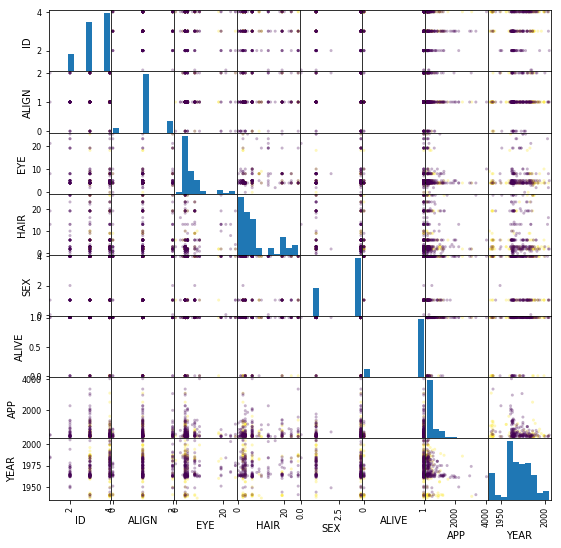

In [58]:
X = both_df.drop(['page_id', 'name','urlslug', 'GSM'], axis=1).dropna()
X = X[X['APPEARANCES']>200]
y = X['dcmar'].values
X = X.drop('dcmar', axis=1).values

df =  pd.DataFrame(X, columns = ['ID', 'ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','YEAR'])


_ = pd.plotting.scatter_matrix(df.dropna(), c=y, alpha = 0.3, figsize=[9,9])

### Regression

The `YEAR` feature has a lot of information contained in it - given that it spans 1930-2013.

In [59]:
y = both_df.dropna()['YEAR'].values
X = both_df.dropna().drop(['YEAR', 'page_id', 'name','urlslug','GSM'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

linreg = linear_model.LinearRegression()

linreg.fit(X_train,y_train)

y_pred = linreg.predict(X_test)

print("R^2: {}".format(linreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.10615096231386734
Root Mean Squared Error: 16.90023499933578


[0.36657235 0.41843769 0.35551006 ... 0.32966555 0.26485166 0.35074036]


/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6594965675057208
Root Mean Squared Error: 0.5835267196061198
0.5822205681538357
[[1441    0]
 [ 744    0]]


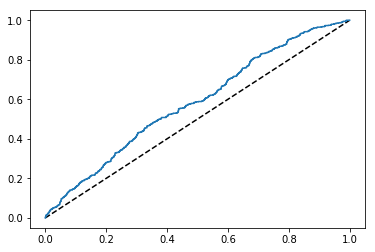

In [60]:
clean_df = both_df.drop(['page_id','name','urlslug', 'ID', 'GSM'], axis=1).dropna()

y = clean_df['dcmar'].dropna().values
X = clean_df.drop('dcmar', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
y_pred.mean()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred.mean()
y_pred_prob = logreg.predict_proba(X_test)[:,1]

print(y_pred_prob)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

In [61]:
clean_df = both_df.drop(['page_id','name','urlslug', 'ID', 'GSM'], axis=1).dropna()

y = clean_df['dcmar'].dropna().values
X = clean_df.drop('dcmar', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

ridge = linear_model.RidgeClassifier(normalize=True)

ridge.fit(X_train,y_train)

y_pred = ridge.predict(X_test)
                 
print("R^2: {}".format(ridge.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.6594965675057208
Root Mean Squared Error: 0.5835267196061198


In [62]:
clean_df = both_df.drop(['page_id','name','urlslug', 'ID', 'GSM'], axis=1).dropna()

y = clean_df['YEAR'].dropna().values
X = clean_df.drop('YEAR', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

ridge = linear_model.Ridge(normalize=True)

ridge.fit(X_train,y_train)

y_pred = ridge.predict(X_test)
                 
print("R^2: {}".format(ridge.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.06673931540099798
Root Mean Squared Error: 17.1693746284062


## Neural Networks
In addition to linear models, we want to see how a simple neural network performs predicting whether or not a character is from the DC or Marvel universe.

In [12]:
clean_df = both_df.drop(['page_id','name','urlslug', 'ID', 'GSM'], axis=1).dropna()

y = clean_df['YEAR'].dropna().values
X = clean_df.drop('YEAR', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(X.shape[-1],)))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mse', 'acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
4629/4629 [==============================] - 1s 312us/step - loss: 2984121.2830 - mean_squared_error: 2984121.2830 - acc: 0.0000e+00
Epoch 2/50
4629/4629 [==============================] - 1s 189us/step - loss: 1108876.4247 - mean_squared_error: 1108876.4247 - acc: 0.0000e+00
Epoch 3/50
4629/4629 [==============================] - 1s 241us/step - loss: 659898.9686 - mean_squared_error: 659898.9686 - acc: 0.0000e+00
Epoch 4/50
4629/4629 [==============================] - 1s 218us/step - loss: 512741.6292 - mean_squared_error: 512741.6292 - acc: 4.3206e-04
Epoch 5/50
4629/4629 [==============================] - 1s 305us/step - loss: 390667.9761 - mean_squared_error: 390667.9761 - acc: 6.4809e-04
Epoch 6/50
4629/4629 [==============================] - 1s 238us/step - loss: 299185.4623 - mean_squared_error: 299185.4623 - acc: 4.3206e-04
Epoch 7/50
4629/4629 [==

It appears that the model we chose performs poorly, with an accuracy around 2%. This could be due to a number of factors having to do with model choices, but based on the performance of the logistic regression model that aims to make the same prediction, it is possible that the data we have is not well suited to answering this question. This could be due to the data set being too small or the character attributes not being differentiable enough between the tow universes.

In [1]:
scores = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[0], scores[0]))
print("{}: {}%".format(model.metrics_names[2], scores[2] * 100))

NameError: name 'model' is not defined

In [ ]:
plt.plot(history.history['acc'])